In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import io
import numpy as np
from sklearn.metrics import r2_score
from sqlalchemy import create_engine


In [2]:
def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=True)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


In [3]:
data_raw = pd.read_csv('raw_island_days2.csv', delimiter = ',')

#get data_raw length
data_raw_length = len(data_raw)
print(data_raw_length)
data_raw.head()

#get split index for train and test
#split_index = int(data_raw_length*.8)
split_index = 25968

#set datatype to datetime for first column in data_raw
data_raw['time'] = pd.to_datetime(data_raw['time'])
data_raw.set_index('time', inplace=True)


#smooth data (averaging small cyclical changes like tide)
sm_len = 7
data_raw_sm = data_raw.rolling(sm_len).mean()

data_train = data_raw_sm.iloc[sm_len-1:(split_index+sm_len-1)]
data_test = data_raw_sm.iloc[(split_index+sm_len-1):]

27001


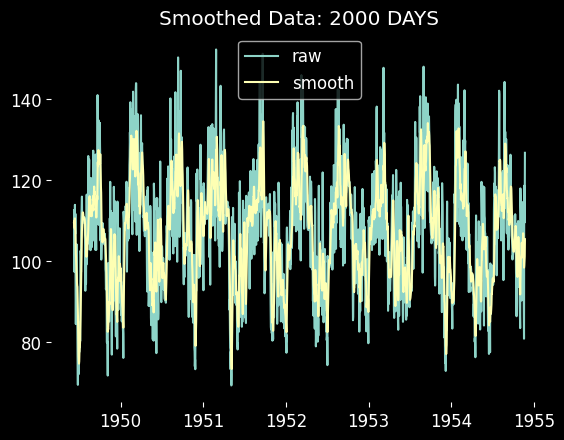

In [4]:
%matplotlib inline

plt.figure()
#resize plot to wide form
plt.rcParams['figure.figsize'] = [20, 4]
#shrink plot labels
plt.rcParams.update({'font.size': 12})
#remove all boundaries
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.plot(data_raw.iloc[(sm_len-1):2000,1], label = 'raw')
plt.plot(data_raw_sm.iloc[(sm_len-1):2000,1], label = 'smooth')
plt.title('Smoothed Data: 2000 DAYS')
plt.legend()
plt.show()

First, we will upload the this dataset into your PostgreSQL database. To do so, we will first set up connection to the database.

## DB connection

In [5]:
## fill your db information
database = '' # FILL IN your db name where tspdb is installed
user = 'postgres' #  FILL IN  user name here
password = '00' #  # FILL IN  password here
host = 'localhost' #  # FILL IN  host name
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
driver="postgresql"
engine = create_engine(driver + '://' + user + ':' + password + '@' + host + '/' + database)

## Create Time Series Table
Now, we will load the dataset into your database.

**Note:** Given the size of the data, this may take a while

In [8]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS island_test_1;")
conn.commit()
conn.close()

# load data into Pandas dataframe
data_train.to_sql('island_test_1', engine, index=True, index_label='time')
data_train.to_csv('island_test_1.csv')
print('Table created and Loaded')

Table created and Loaded


In [7]:
# lets query our table mixturets2 to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from island_test_1 order by time DESC limit 10;", conn)
conn.close()
df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_84233/3493023257.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from island_test_1 order by time DESC limit 10;", conn)


,time,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
0,2020-07-13,115.678764,120.043597,121.063759,99.201152,80.583941,72.041647,70.740495,76.532868,91.953347,...,134.082945,122.126351,89.564462,75.965181,71.841459,74.390592,84.532893,103.697053,114.335904,114.405920
1,2020-07-12,115.299558,120.621152,122.990404,99.093403,80.135099,71.391016,69.703106,74.748196,89.309444,...,136.403333,123.505551,89.451307,75.287613,71.021891,73.632856,84.042262,103.802369,115.165918,114.519143
2,2020-07-11,118.389015,122.972548,124.112625,99.560962,80.451107,71.351547,69.133191,73.193564,85.924867,...,139.565602,120.542201,88.171924,74.715387,70.610369,73.156764,83.121370,101.762752,115.386126,117.478337
3,2020-07-10,123.090524,127.117814,127.871786,100.467480,78.369782,67.753653,64.665785,68.154247,80.860611,...,147.316759,118.717767,85.558864,72.355572,68.138563,70.196828,79.332742,98.546498,117.773931,122.610434
4,2020-07-09,125.678786,127.489506,127.532604,102.091509,79.019587,67.572281,63.817370,66.464660,77.733564,...,150.920841,117.424496,82.754987,69.081836,64.763495,67.004996,76.871117,98.042373,121.709462,127.445479
5,2020-07-08,126.312939,128.259930,129.135582,101.437278,76.489199,64.628568,60.933669,63.904612,76.198176,...,152.886520,113.901717,82.658143,69.210650,64.721216,66.818569,76.774032,98.981756,123.053474,128.307258
6,2020-07-07,125.740116,126.576919,126.323277,101.334575,77.990290,66.617043,63.223851,66.552845,79.130346,...,150.469588,110.188343,84.056837,71.563227,67.007667,68.663874,77.659266,98.109896,122.660636,128.295430
7,2020-07-06,123.989323,123.854833,122.984725,99.805529,78.952297,68.941636,66.234534,69.912132,82.447875,...,147.427786,108.968369,83.724825,71.614707,67.584310,69.884732,79.538436,99.689305,122.699875,127.408811
8,2020-07-05,124.275986,122.876599,120.545192,99.841675,79.534342,69.669476,67.130999,71.188241,85.099860,...,144.183765,105.786219,82.603602,71.788700,68.510344,71.259676,81.061469,100.796795,122.792249,127.655994
9,2020-07-04,122.449377,121.456389,118.778435,97.886836,78.454363,69.301492,67.405900,72.378311,88.234643,...,141.356642,108.641553,84.076610,72.120145,68.463466,71.071533,80.965394,101.650453,123.023958,125.802312


## Create prediction index

In [8]:
# get all columns and format it
cols = '{"'+'","'.join(data_train.columns[:])+'"}'
query = """select create_pindex('island_test_1', 'time','%s','pindex_isl1', k=> 20);"""%cols
print('formated query : ',query )
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(query)
conn.commit()
conn.close()

formated query :  select create_pindex('island_test_1', 'time','{"MT_001","MT_002","MT_003","MT_004","MT_005","MT_006","MT_007","MT_008","MT_009","MT_010","MT_011","MT_012","MT_013","MT_014","MT_015","MT_016","MT_017","MT_018","MT_019","MT_020"}','pindex_isl1', k=> 20);


In [9]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices()", conn)
df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_84233/1280691254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from list_pindices()", conn)


,index_name,value_columns,relation,time_column,initial_timestamp,last_timestamp,agg_interval,uncertainty_quantification
0,basic_pindex,[ts],ts_basic_ts_5_5,time,2012-10-01 00:00:00,2012-10-06 18:53:15,00:00:05,True
1,pindex_isl1,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
2,pindex_isl2,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_2,time,2015-01-16 00:00:00,2020-07-07 00:00:00,24:00:00,True
3,mixturets_var_pindex,[ts],mixturets_var,time,0,99999,1 units,True
4,mixturets2_pindex,[ts],mixturets2,time,0,100000,1 units,True
5,pindex_e20,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
6,pindex_isl3,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_3,time,2019-12-21 00:00:00,2020-07-07 00:00:00,24:00:00,True


/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_84233/1916255716.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select * from predict('island_test_1','MT_020','2020-07-13 00:00:00'\


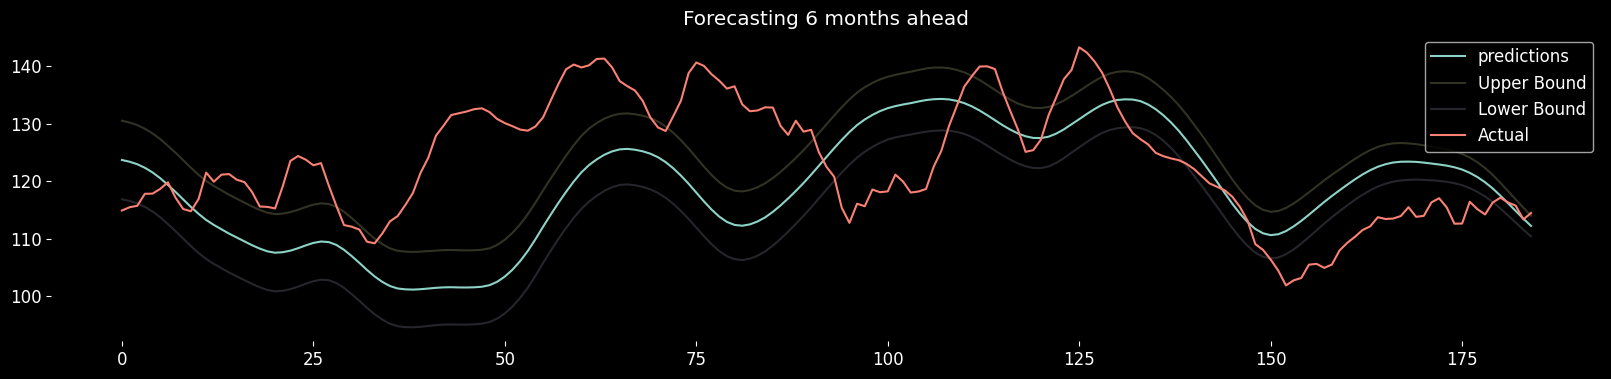

In [10]:
%matplotlib inline
df = pd.read_sql_query('''select * from predict('island_test_1','MT_020','2020-07-13 00:00:00'\
,'2021-01-13 00:00:00','pindex_isl1');''', conn)

plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot( df['ub'], label = 'Upper Bound', alpha = 0.2)
plt.plot(df['lb'], label = 'Lower Bound', alpha = 0.2)
plt.plot(data_test['MT_020'].values[:len(df['prediction'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 6 months ahead')
plt.legend()
plt.show()

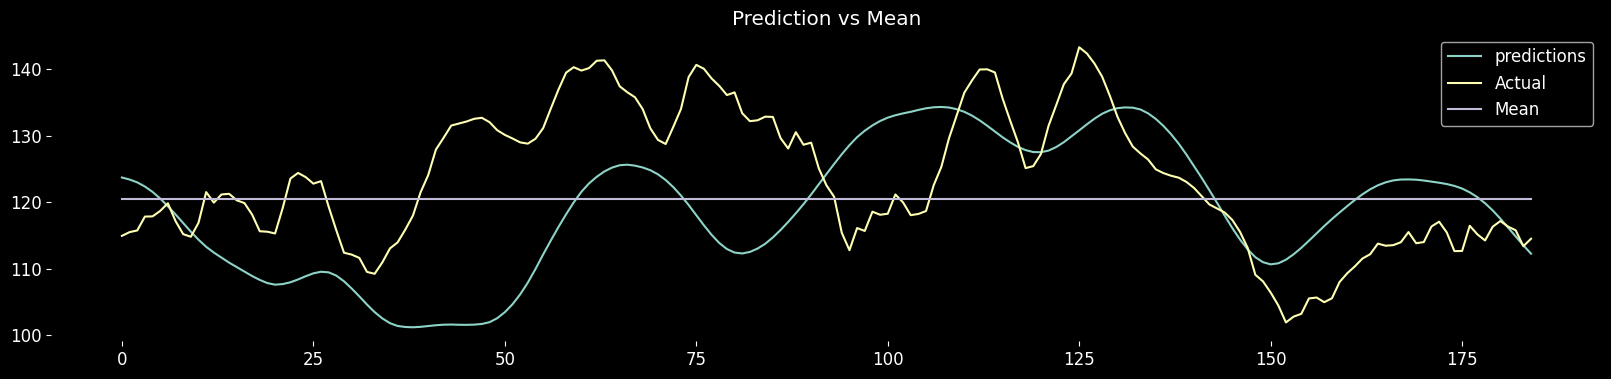

In [23]:
#create series of mean values
df_mean = df['prediction']
df_mean = df_mean / df_mean * data_train['MT_020'].values[:len(df['prediction'])].mean()


plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot(data_test['MT_020'].values[:len(df['prediction'])], label = 'Actual', alpha = 1.0)
plt.plot(df_mean, label = 'Mean', alpha = 1.0)
plt.title('Prediction vs Mean')
plt.legend()
plt.show()

In [25]:
Y = data_test['MT_020'].values[:len(df['prediction'])]
Y_m = df_mean
Y_h = df['prediction']
wape_test = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape_test)
wape_mean = np.sum(np.abs(Y-Y_m))/np.sum(np.abs(Y))
print ('Mean error (WAPE):',wape_mean)

Forecasting accuracy (WAPE): 0.0863000245338184
Mean error (WAPE): 0.0712851375322241


### Forecast all transects for the next 2 years

In [26]:
# predict for 2 years
seasons = 4
s_len = 180

#initialise prediction array
predictions = np.zeros((len(data_test.columns),seasons*s_len))
ub = np.zeros((len(data_test.columns),seasons*s_len))
lb = np.zeros((len(data_test.columns),seasons*s_len))
actual = data_test.values[:seasons*s_len,:]
# specify start time
start_time = pd.Timestamp('2020-07-13 00:00:00')

for season in range(seasons):
    print('season: ',season+1)
    # get the final time stamp in the day
    end_time = start_time + pd.Timedelta(days=s_len-1)
    # convert timestamps to string
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    print('starting from %s to  %s '%(start_str,end_str))
    # predict for each transect
    for i, column in enumerate(data_test.columns):
        #print('predicting column:%s for season %s '%(column,season+1))
        
        ## execute forecast query
        df_30 = pd.read_sql_query('''select * from predict('island_test_1','%s','%s'\
    ,'%s','pindex_isl1');'''%(column, start_str, end_str), conn)
        predictions[i,season*s_len:(season+1)*s_len] = df_30['prediction']
        ub[i,season*s_len:(season+1)*s_len] = df_30['ub']
        lb[i,season*s_len:(season+1)*s_len] = df_30['lb']
    # insert the already predicted values into the database
    df_insert = data_test.iloc[season*s_len:s_len*(season+1),:]
    bulk_insert(df_insert, 'island_test_1', conn_string)
    # update start_time
    start_time = start_time + pd.Timedelta(days=s_len)


season:  1
starting from 2020-07-13 00:00:00 to  2021-01-08 00:00:00 


/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_36358/2046603252.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_30 = pd.read_sql_query('''select * from predict('island_test_1','%s','%s'\


season:  2
starting from 2021-01-09 00:00:00 to  2021-07-07 00:00:00 
season:  3
starting from 2021-07-08 00:00:00 to  2022-01-03 00:00:00 
season:  4
starting from 2022-01-04 00:00:00 to  2022-07-02 00:00:00 


Calculating error using the metric Weighted Absolute Percent Error (WAPE) which is calculated as:

$\text{WAPE} = \frac{\sum_i \sum_j |Y_{ij}-\hat{Y}_{ij}|} {\sum_i \sum_j |Y_{ij}|} $

Where:
- $Y_{ij}$ is the actual observation for time series j at time i 
- $\hat{Y}_{ij}$ is the predicted value for time series j at time i 

In [27]:
Y = actual[:,:]
Y_h = predictions.T[:,:]
wape = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape)

Forecasting accuracy (WAPE): 0.07444920931874238


# Visualizing all the 20 transects

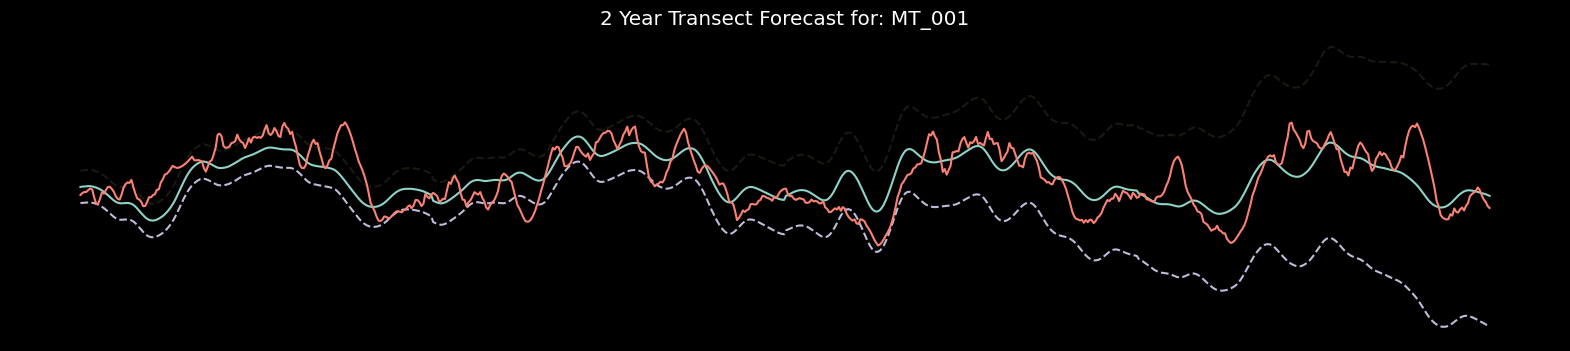

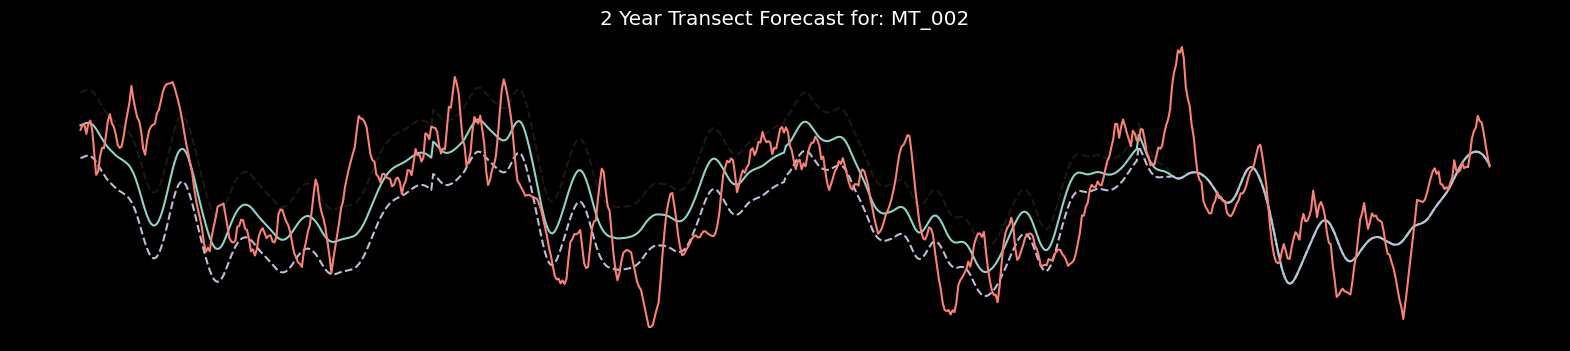

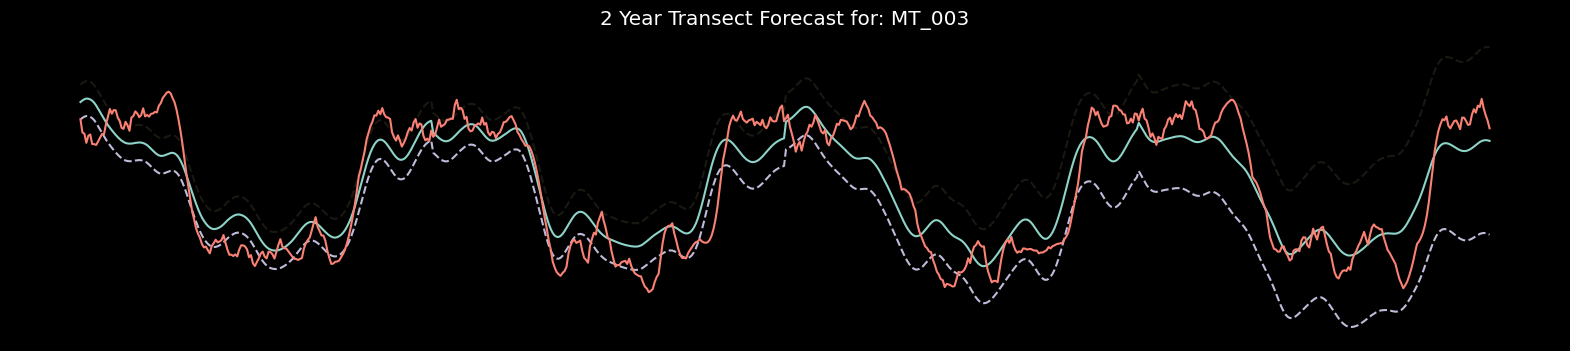

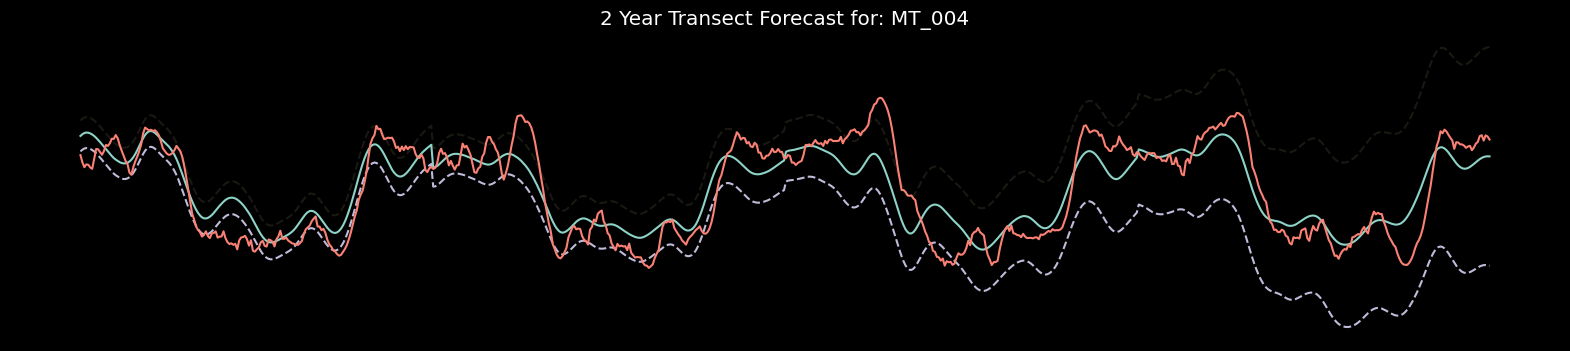

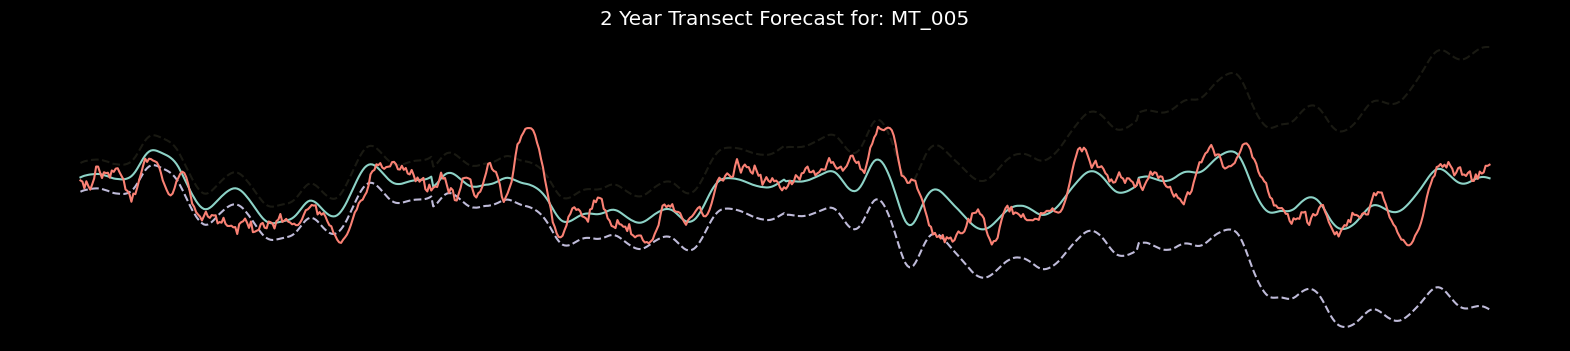

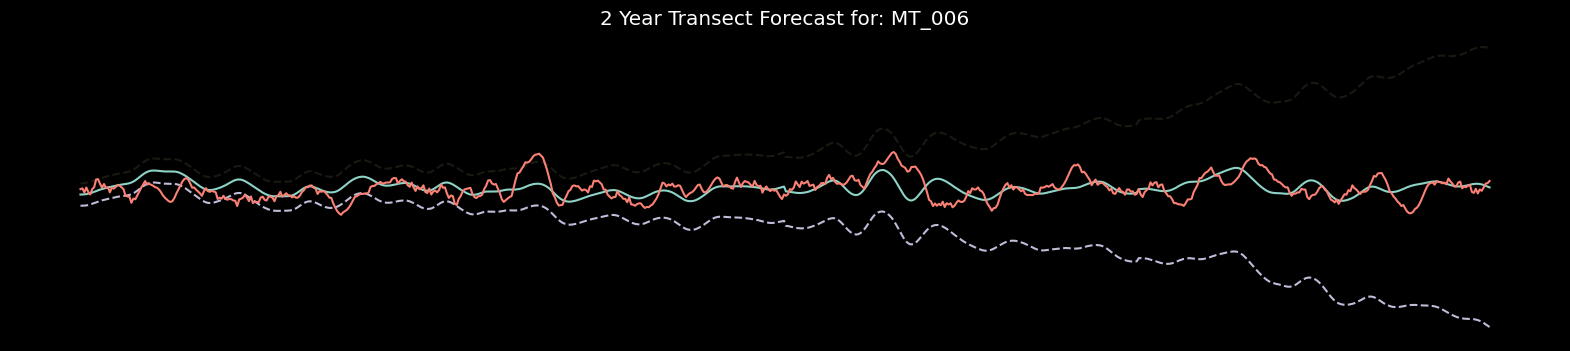

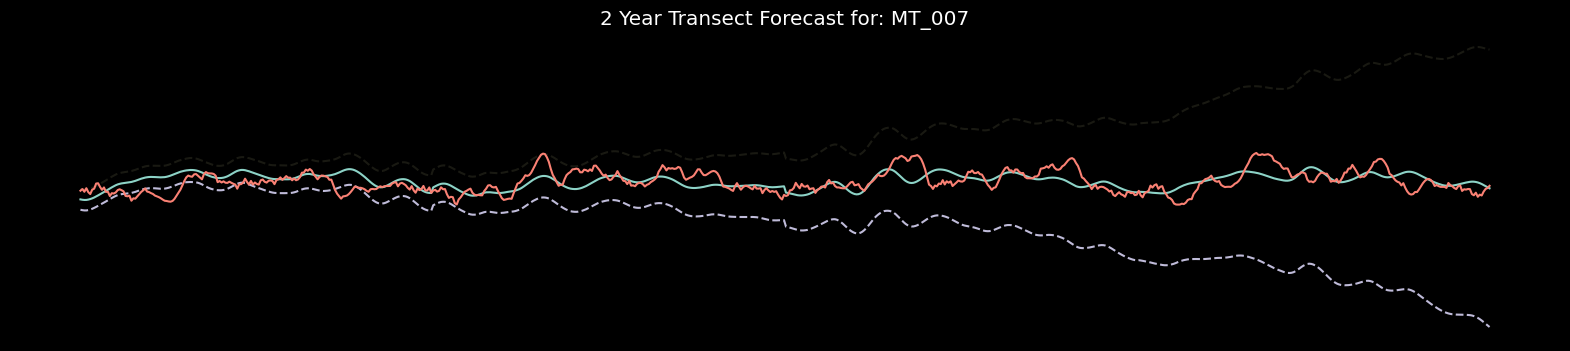

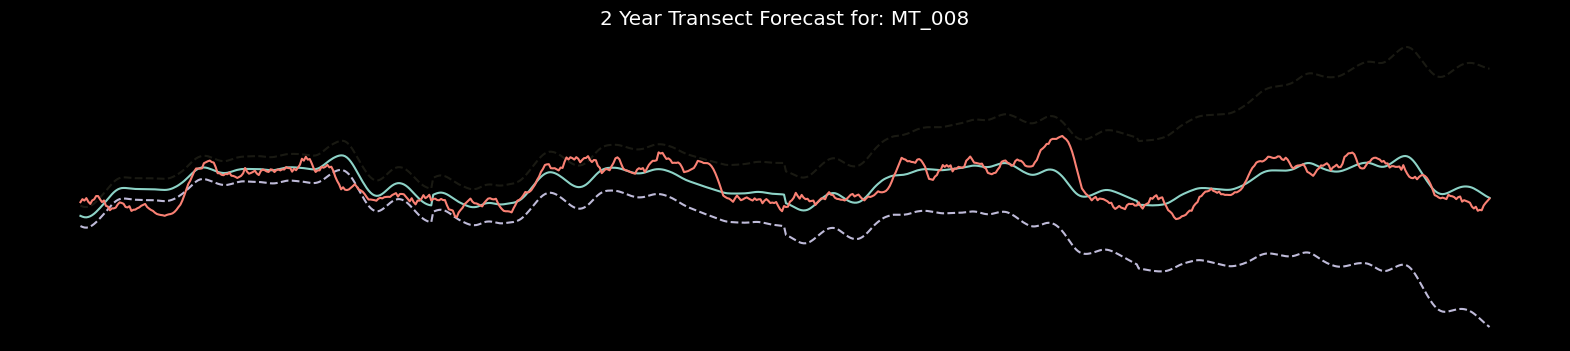

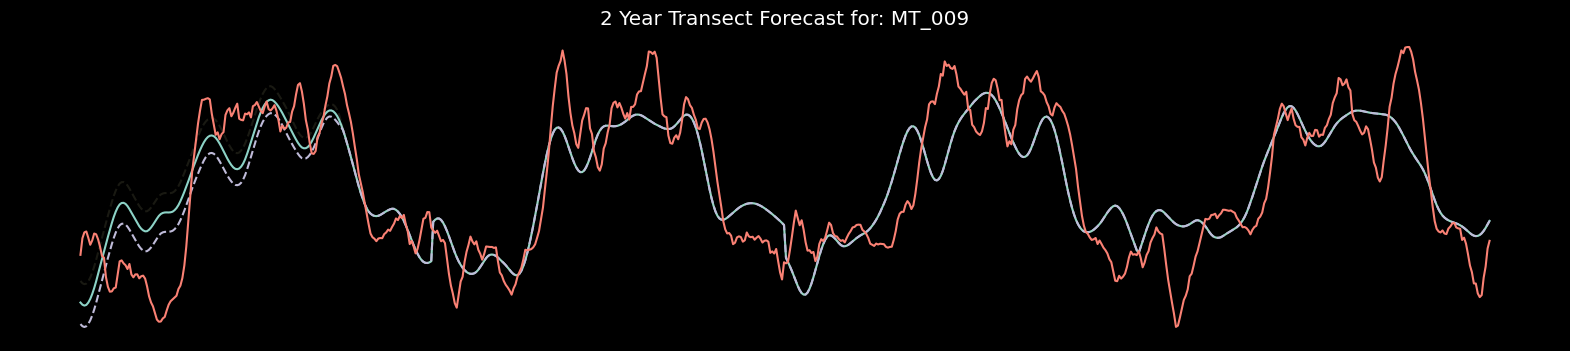

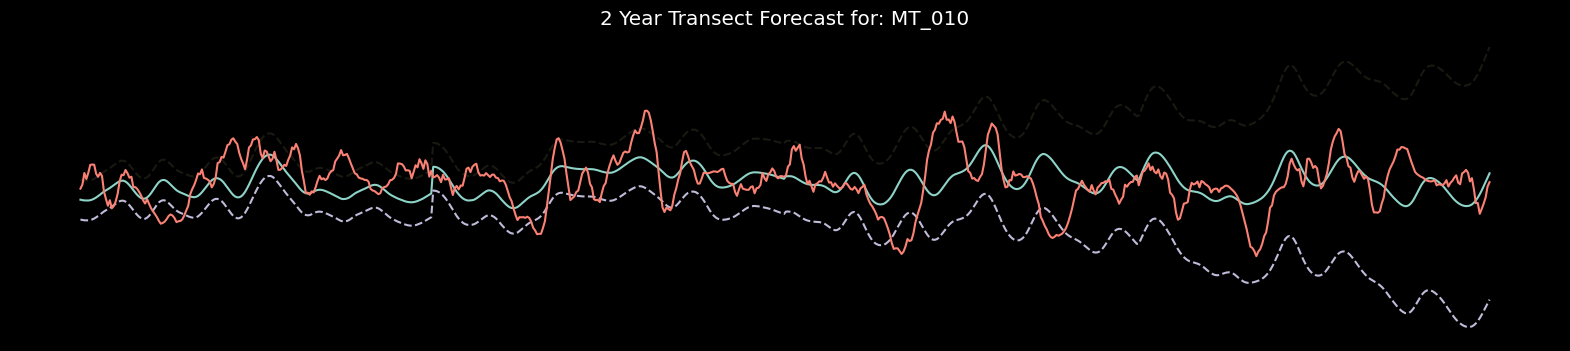

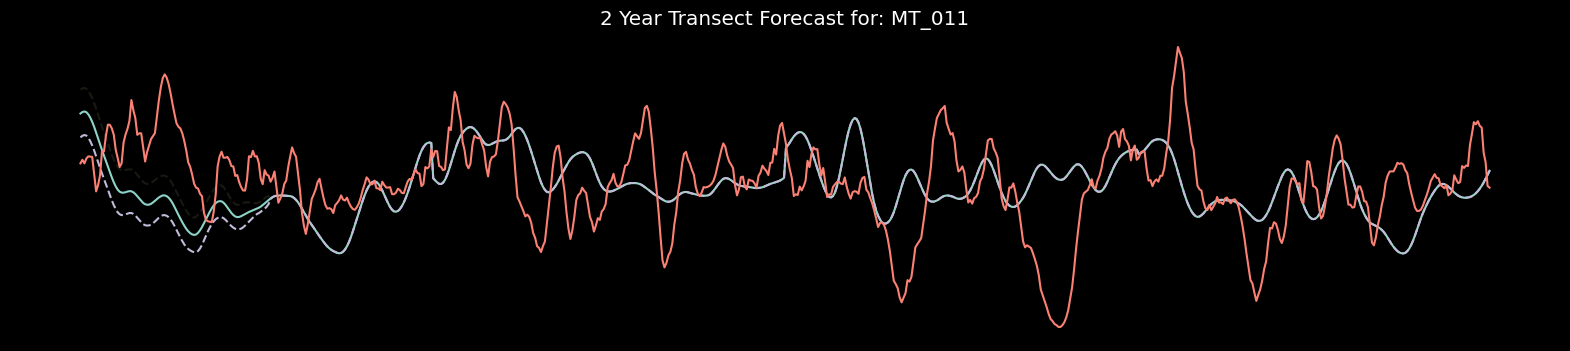

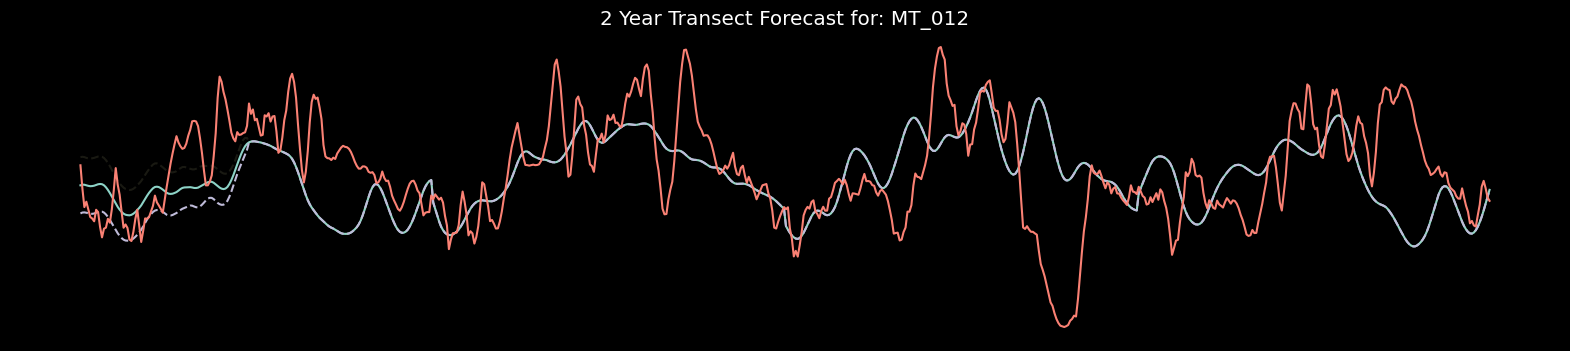

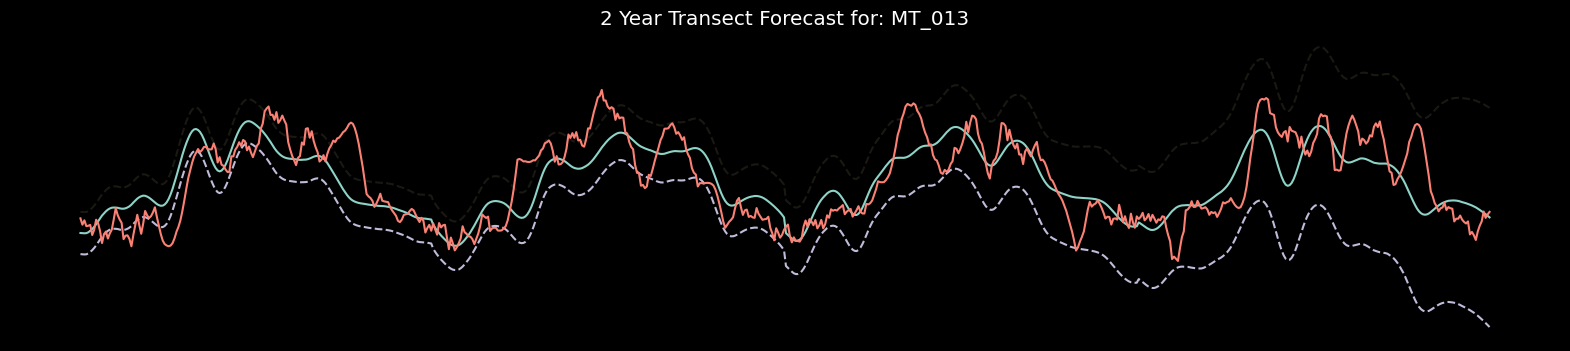

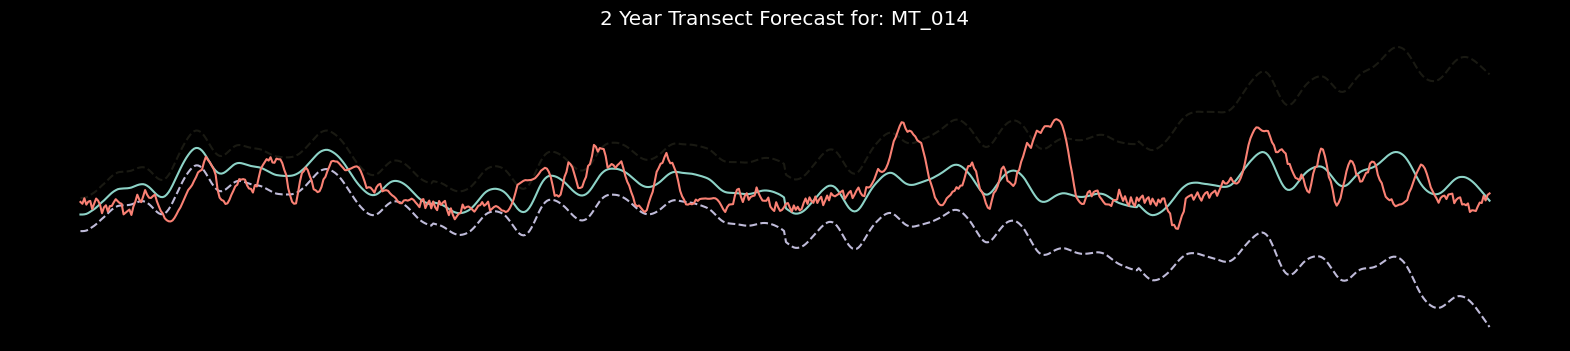

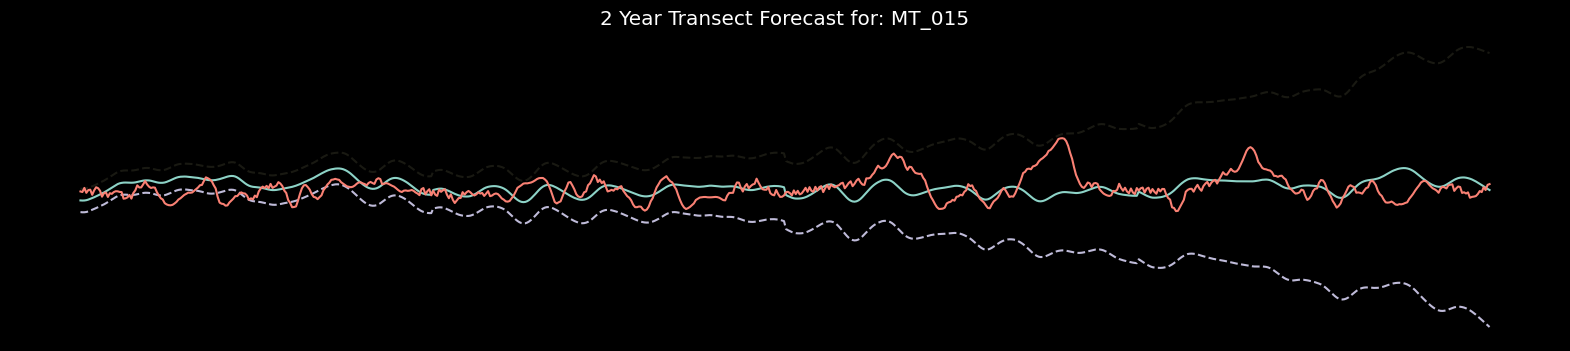

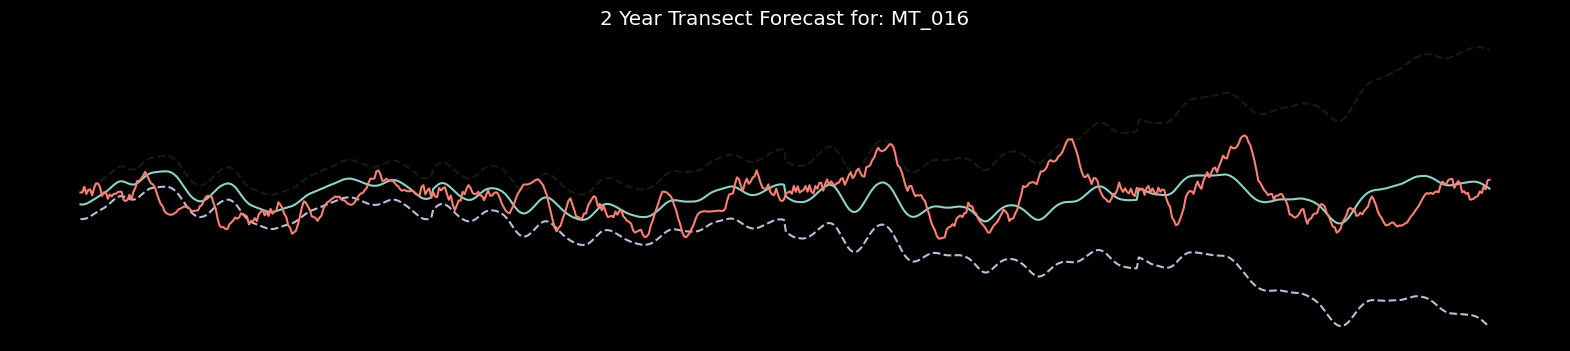

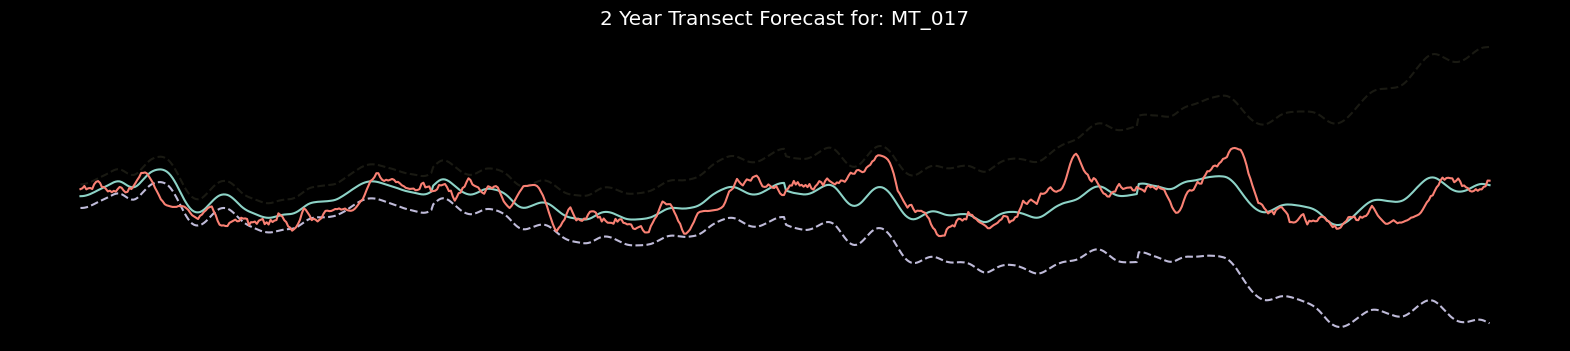

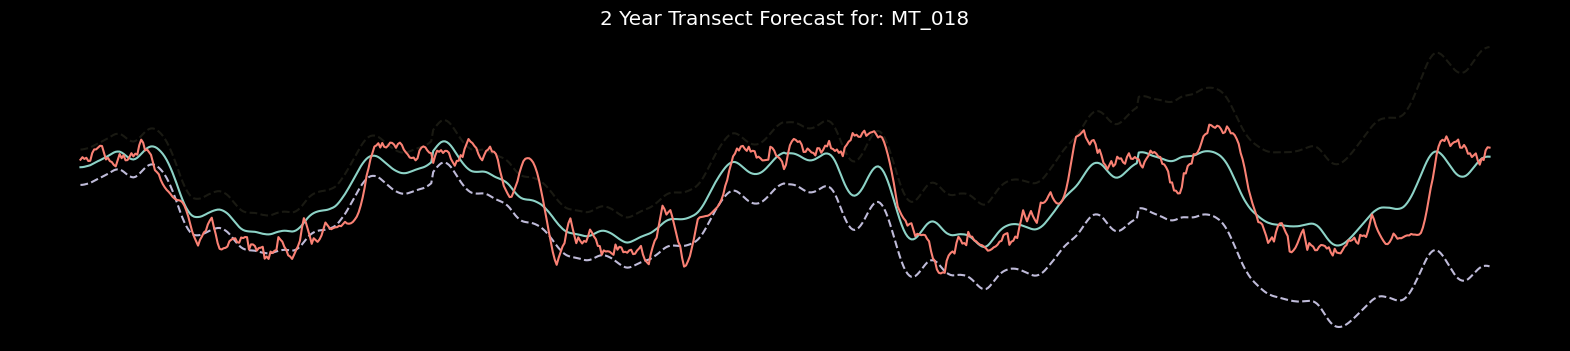

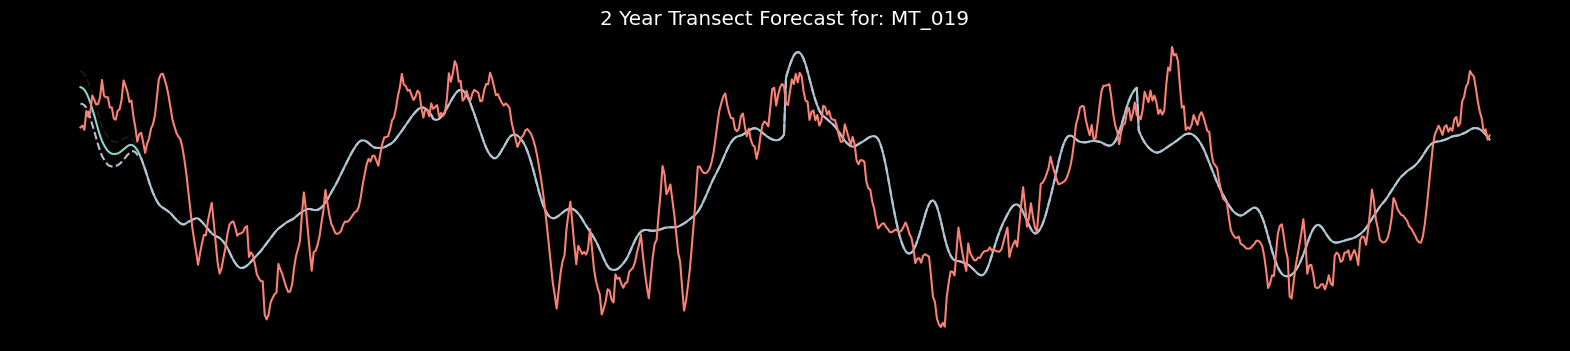

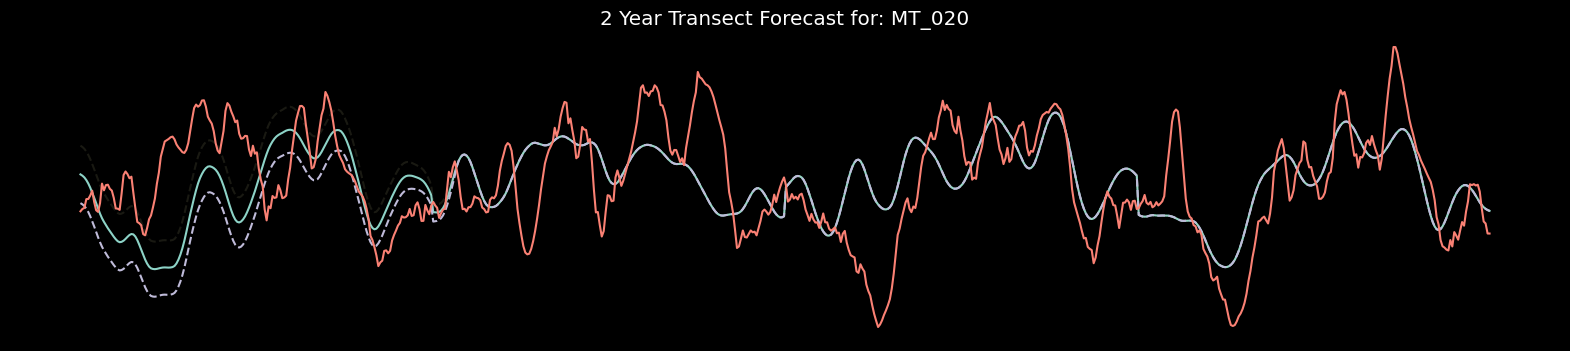

In [32]:
%matplotlib inline
for i in range(20):
    #hide x and y axis ticks
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    #hide labels
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    plt.figure()
    plt.title('2 Year Transect Forecast for: %s'%data_test.columns[i])
    plt.plot(predictions[i,:seasons*s_len],label= 'predictions')
    plt.plot(ub[i,:seasons*s_len],'--',label= 'upper bound', alpha = 0.1)
    plt.plot(lb[i,:seasons*s_len],'--',label= 'lower bound')
    plt.plot(actual[:seasons*s_len,i],label = 'actual')

plt.show()

In [39]:

#write predictions to csv
dp = pd.DataFrame(predictions[:,:seasons*s_len].T, columns = data_test.columns)
dp.to_csv('island_test_1_pred.csv')

da = pd.DataFrame(actual[:seasons*s_len,:], columns = data_test.columns)
da.to_csv('island_test_1_act.csv')